# Complete Emotion Detection Analysis

## End-to-End Machine Learning Pipeline for Text Emotion Classification

This notebook demonstrates a comprehensive machine learning pipeline for emotion detection in text data, covering:

1. **Data Exploration & Analysis (EDA)**
2. **Feature Engineering & Preprocessing**
3. **Model Training & Selection**
4. **Model Evaluation & Metrics**
5. **Model Deployment & Inference**

### Dataset Overview
- **Total Samples**: 240 diverse text examples
- **Emotions**: Happy, Sad, Angry, Neutral, Fear, Surprise (40 samples each)
- **Text Variety**: Real-world scenarios, different contexts and expressions

## 1. Setup and Data Loading

In [24]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import time
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

# Machine Learning libraries
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, roc_curve, auc
)
from sklearn.pipeline import Pipeline

# Text preprocessing
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Download NLTK data
try:
    nltk.download('punkt', quiet=True)
    nltk.download('stopwords', quiet=True)
    nltk.download('wordnet', quiet=True)
    nltk.download('omw-1.4', quiet=True)
except:
    pass

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")

print("All libraries imported successfully!")
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")

All libraries imported successfully!
Pandas version: 2.2.2
NumPy version: 1.26.4


In [25]:
# Load the comprehensive emotion dataset
df = pd.read_csv('comprehensive_emotion_dataset.csv')

print(f"Dataset loaded successfully!")
print(f"Total samples: {len(df)}")
print(f"Unique emotions: {df['emotion'].nunique()}")
print(f"Emotions: {sorted(df['emotion'].unique())}")

# Display first few rows
print("\nFirst 5 rows:")
df.head()

Dataset loaded successfully!
Total samples: 240
Unique emotions: 6
Emotions: ['Angry', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']

First 5 rows:


,text,emotion
0,I'm absolutely thrilled about this promotion!,Happy
1,"What a beautiful morning, I feel fantastic!",Happy
2,Just got accepted to my dream university!,Happy
3,My wedding day was the most magical experience,Happy
4,I can't stop smiling after that wonderful news,Happy


## 2. Exploratory Data Analysis (EDA)

In [26]:
# Dataset statistics
print("=== Dataset Statistics ===")
print(f"Total samples: {len(df)}")
print(f"Unique emotions: {df['emotion'].nunique()}")
print(f"Average text length: {df['text'].str.len().mean():.1f} characters")
print(f"Min text length: {df['text'].str.len().min()} characters")
print(f"Max text length: {df['text'].str.len().max()} characters")
print(f"Median text length: {df['text'].str.len().median():.1f} characters")

# Check for missing values
print(f"\nMissing values:")
print(df.isnull().sum())

# Emotion distribution
print("\n=== Emotion Distribution ===")
emotion_counts = df['emotion'].value_counts()
emotion_percentages = df['emotion'].value_counts(normalize=True) * 100

distribution_df = pd.DataFrame({
    'Count': emotion_counts,
    'Percentage': emotion_percentages
})
print(distribution_df)

=== Dataset Statistics ===
Total samples: 240
Unique emotions: 6
Average text length: 41.5 characters
Min text length: 33 characters
Max text length: 54 characters
Median text length: 42.0 characters

Missing values:
text       0
emotion    0
dtype: int64

=== Emotion Distribution ===
          Count  Percentage
emotion                    
Happy        40   16.666667
Sad          40   16.666667
Angry        40   16.666667
Neutral      40   16.666667
Fear         40   16.666667
Surprise     40   16.666667


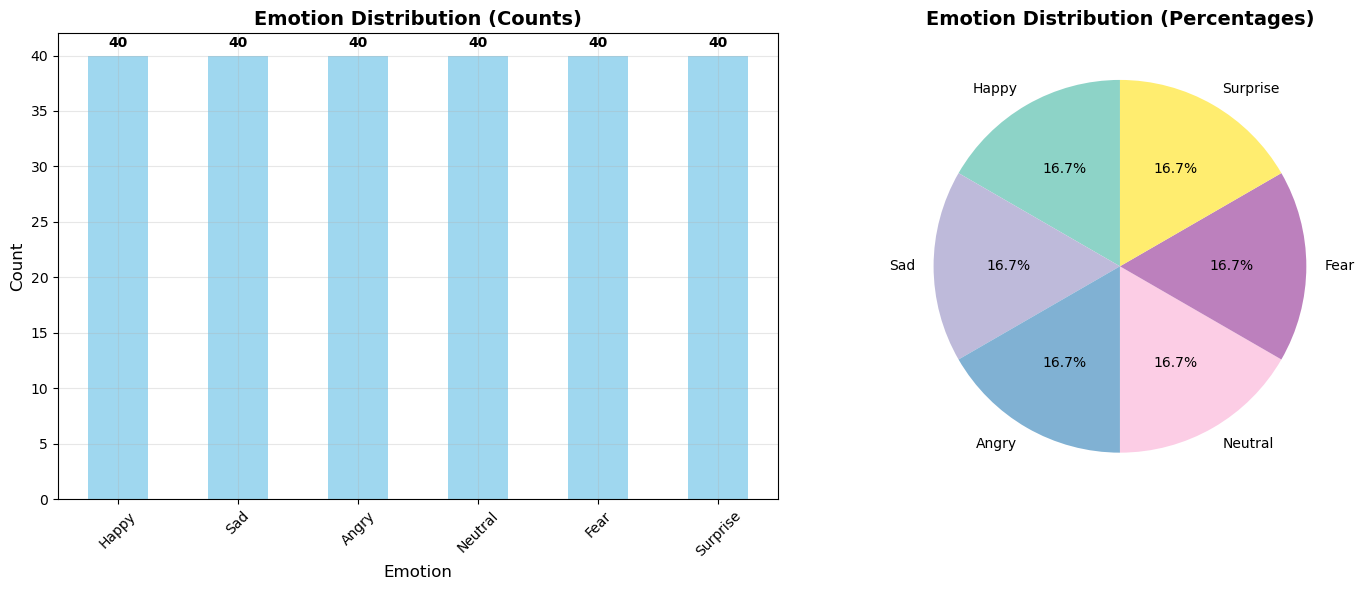


Dataset Balance Check:
Standard deviation / Mean ratio: 0.0000
Dataset is balanced


In [27]:
# Visualize emotion distribution
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Bar plot
emotion_counts.plot(kind='bar', ax=axes[0], color='skyblue', alpha=0.8)
axes[0].set_title('Emotion Distribution (Counts)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Emotion', fontsize=12)
axes[0].set_ylabel('Count', fontsize=12)
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(True, alpha=0.3)

# Add count labels on bars
for i, v in enumerate(emotion_counts.values):
    axes[0].text(i, v + 0.5, str(v), ha='center', va='bottom', fontweight='bold')

# Pie chart
colors = plt.cm.Set3(np.linspace(0, 1, len(emotion_counts)))
axes[1].pie(emotion_counts.values, labels=emotion_counts.index, autopct='%1.1f%%', 
           colors=colors, startangle=90)
axes[1].set_title('Emotion Distribution (Percentages)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

# Check if dataset is balanced
balance_check = emotion_counts.std() / emotion_counts.mean()
print(f"\nDataset Balance Check:")
print(f"Standard deviation / Mean ratio: {balance_check:.4f}")
print(f"Dataset is {'balanced' if balance_check < 0.1 else 'imbalanced'}")

In [28]:
# Text length analysis
df['text_length'] = df['text'].str.len()
df['word_count'] = df['text'].str.split().str.len()

# Statistical summary by emotion
print("=== Text Length Statistics by Emotion ===")
text_stats = df.groupby('emotion')['text_length'].agg(['mean', 'std', 'min', 'max', 'median']).round(2)
print(text_stats)

print("\n=== Word Count Statistics by Emotion ===")
word_stats = df.groupby('emotion')['word_count'].agg(['mean', 'std', 'min', 'max', 'median']).round(2)
print(word_stats)

=== Text Length Statistics by Emotion ===
           mean   std  min  max  median
emotion                                
Angry     41.65  3.70   33   49    42.0
Fear      40.98  4.07   34   49    40.0
Happy     42.72  3.37   34   48    43.5
Neutral   41.65  3.63   33   50    42.0
Sad       39.85  2.93   34   46    39.5
Surprise  41.95  4.35   33   54    42.5

=== Word Count Statistics by Emotion ===
          mean   std  min  max  median
emotion                               
Angry     6.25  0.93    5    8     6.0
Fear      6.90  0.67    6    9     7.0
Happy     7.05  0.96    6    9     7.0
Neutral   6.50  0.93    5    9     6.0
Sad       6.62  0.81    5    8     7.0
Surprise  6.48  1.01    5   10     6.0


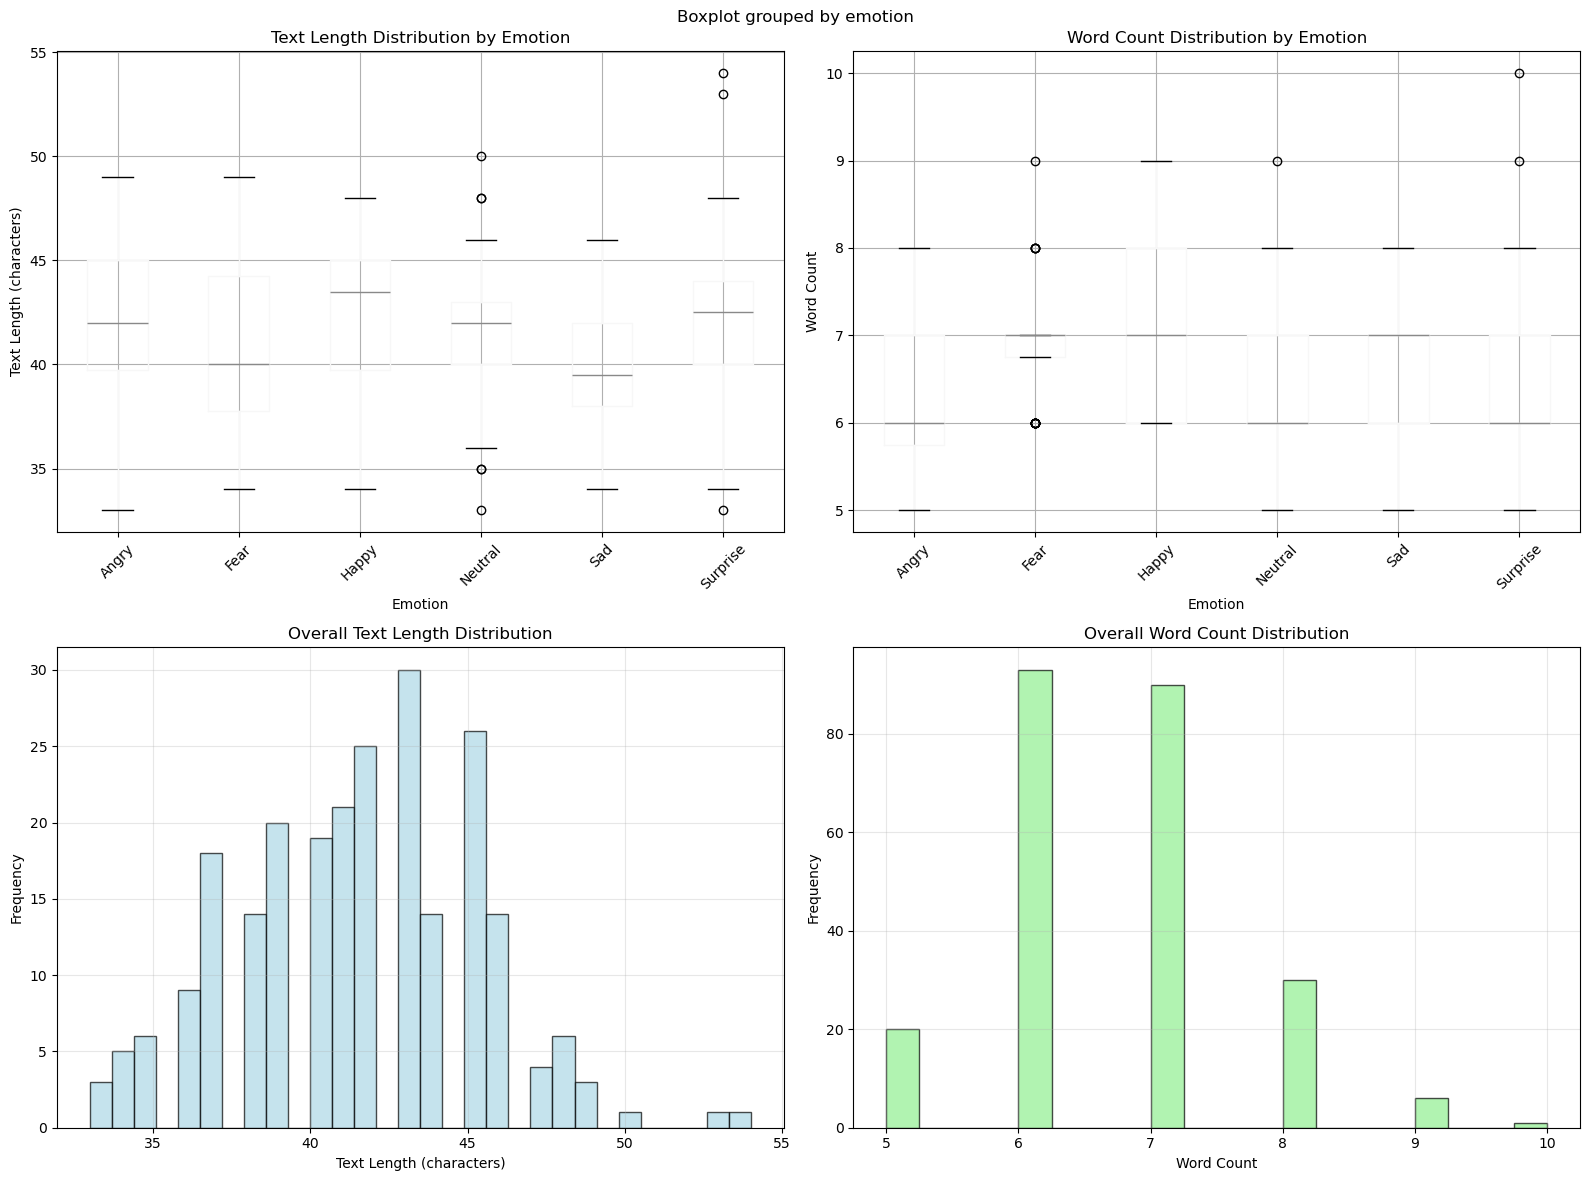

In [29]:
# Visualize text length distributions
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Text length by emotion (box plot)
df.boxplot(column='text_length', by='emotion', ax=axes[0,0])
axes[0,0].set_title('Text Length Distribution by Emotion')
axes[0,0].set_xlabel('Emotion')
axes[0,0].set_ylabel('Text Length (characters)')
axes[0,0].tick_params(axis='x', rotation=45)

# Word count by emotion (box plot)
df.boxplot(column='word_count', by='emotion', ax=axes[0,1])
axes[0,1].set_title('Word Count Distribution by Emotion')
axes[0,1].set_xlabel('Emotion')
axes[0,1].set_ylabel('Word Count')
axes[0,1].tick_params(axis='x', rotation=45)

# Overall text length histogram
axes[1,0].hist(df['text_length'], bins=30, alpha=0.7, color='lightblue', edgecolor='black')
axes[1,0].set_title('Overall Text Length Distribution')
axes[1,0].set_xlabel('Text Length (characters)')
axes[1,0].set_ylabel('Frequency')
axes[1,0].grid(True, alpha=0.3)

# Overall word count histogram
axes[1,1].hist(df['word_count'], bins=20, alpha=0.7, color='lightgreen', edgecolor='black')
axes[1,1].set_title('Overall Word Count Distribution')
axes[1,1].set_xlabel('Word Count')
axes[1,1].set_ylabel('Frequency')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 3. Text Preprocessing and Feature Engineering

In [30]:
# Text preprocessing class
class TextPreprocessor:
    def __init__(self):
        self.lemmatizer = WordNetLemmatizer()
        try:
            self.stop_words = set(stopwords.words('english'))
        except:
            self.stop_words = set()
    
    def clean_text(self, text):
        """Clean and preprocess text"""
        if pd.isna(text) or not isinstance(text, str):
            return ""
        
        # Convert to lowercase
        text = text.lower()
        
        # Remove URLs and email addresses
        text = re.sub(r'http\S+|www.\S+|\S+@\S+', '', text)
        
        # Remove mentions and hashtags
        text = re.sub(r'@\w+|#\w+', '', text)
        
        # Keep emotion-related punctuation (! and ?) but remove others
        text = re.sub(r'[^\w\s!?]', ' ', text)
        
        # Normalize multiple exclamation/question marks
        text = re.sub(r'!+', '!', text)
        text = re.sub(r'\?+', '?', text)
        
        # Remove extra whitespace
        text = re.sub(r'\s+', ' ', text)
        
        return text.strip()
    
    def tokenize_and_lemmatize(self, text):
        """Tokenize and lemmatize text"""
        try:
            tokens = word_tokenize(text)
            processed_tokens = []
            
            for token in tokens:
                if token.lower() not in self.stop_words and len(token) > 2:
                    try:
                        lemmatized = self.lemmatizer.lemmatize(token.lower())
                        processed_tokens.append(lemmatized)
                    except:
                        processed_tokens.append(token.lower())
            
            return ' '.join(processed_tokens)
        except:
            # Fallback if NLTK processing fails
            words = text.split()
            filtered_words = [word for word in words if len(word) > 2]
            return ' '.join(filtered_words)
    
    def preprocess(self, text):
        """Complete preprocessing pipeline"""
        cleaned = self.clean_text(text)
        processed = self.tokenize_and_lemmatize(cleaned)
        return processed

# Initialize preprocessor
preprocessor = TextPreprocessor()

# Show preprocessing examples
print("=== Text Preprocessing Examples ===")
sample_texts = [
    "I'm absolutely thrilled about this promotion!",
    "This is completely unacceptable!!!",
    "I feel so sad and lonely today...",
    "The meeting is scheduled for 2 PM tomorrow.",
    "I'm terrified of what might happen next???"
]

for i, text in enumerate(sample_texts, 1):
    processed = preprocessor.preprocess(text)
    print(f"\nExample {i}:")
    print(f"Original:  {text}")
    print(f"Processed: {processed}")

=== Text Preprocessing Examples ===

Example 1:
Original:  I'm absolutely thrilled about this promotion!
Processed: absolutely thrilled about this promotion!

Example 2:
Original:  This is completely unacceptable!!!
Processed: this completely unacceptable!

Example 3:
Original:  I feel so sad and lonely today...
Processed: feel sad and lonely today

Example 4:
Original:  The meeting is scheduled for 2 PM tomorrow.
Processed: the meeting scheduled for tomorrow

Example 5:
Original:  I'm terrified of what might happen next???
Processed: terrified what might happen next?


In [31]:
# Apply preprocessing to the entire dataset
print("Preprocessing the entire dataset...")
df['processed_text'] = df['text'].apply(preprocessor.preprocess)

# Remove empty processed texts
df_clean = df[df['processed_text'].str.strip() != ''].copy()

print(f"Dataset size before preprocessing: {len(df)}")
print(f"Dataset size after preprocessing: {len(df_clean)}")

# Show processed dataset sample
print("\n=== Processed Dataset Sample ===")
display_df = df_clean[['text', 'processed_text', 'emotion']].head(10)
for idx, row in display_df.iterrows():
    print(f"\nEmotion: {row['emotion']}")
    print(f"Original: {row['text']}")
    print(f"Processed: {row['processed_text']}")
    print("-" * 80)

Preprocessing the entire dataset...
Dataset size before preprocessing: 240
Dataset size after preprocessing: 240

=== Processed Dataset Sample ===

Emotion: Happy
Original: I'm absolutely thrilled about this promotion!
Processed: absolutely thrilled about this promotion!
--------------------------------------------------------------------------------

Emotion: Happy
Original: What a beautiful morning, I feel fantastic!
Processed: what beautiful morning feel fantastic!
--------------------------------------------------------------------------------

Emotion: Happy
Original: Just got accepted to my dream university!
Processed: just got accepted dream university!
--------------------------------------------------------------------------------

Emotion: Happy
Original: My wedding day was the most magical experience
Processed: wedding day was the most magical experience
--------------------------------------------------------------------------------

Emotion: Happy
Original: I can't stop sm

## 4. Feature Extraction and Data Preparation

In [32]:
# Prepare features and labels
X = df_clean['processed_text']
y = df_clean['emotion']

# Check class distribution after preprocessing
print("=== Class Distribution After Preprocessing ===")
class_dist = y.value_counts()
print(class_dist)

# Split the data
test_size = 0.25
random_state = 42

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=test_size, random_state=random_state, stratify=y
)

print(f"\n=== Data Split ===")
print(f"Training set size: {len(X_train)} ({len(X_train)/len(X)*100:.1f}%)")
print(f"Test set size: {len(X_test)} ({len(X_test)/len(X)*100:.1f}%)")

# Check class distribution in train/test sets
print(f"\nTraining set class distribution:")
print(y_train.value_counts())
print(f"\nTest set class distribution:")
print(y_test.value_counts())

=== Class Distribution After Preprocessing ===
emotion
Happy       40
Sad         40
Angry       40
Neutral     40
Fear        40
Surprise    40
Name: count, dtype: int64

=== Data Split ===
Training set size: 180 (75.0%)
Test set size: 60 (25.0%)

Training set class distribution:
emotion
Fear        30
Sad         30
Surprise    30
Angry       30
Happy       30
Neutral     30
Name: count, dtype: int64

Test set class distribution:
emotion
Surprise    10
Angry       10
Sad         10
Neutral     10
Fear        10
Happy       10
Name: count, dtype: int64


In [33]:
# Feature extraction with TF-IDF
# Compare different vectorization approaches

vectorizers = {
    'TF-IDF (1-2 grams)': TfidfVectorizer(
        max_features=5000,
        ngram_range=(1, 2),
        min_df=1,
        max_df=0.95,
        sublinear_tf=True
    ),
    'TF-IDF (1 gram)': TfidfVectorizer(
        max_features=3000,
        ngram_range=(1, 1),
        min_df=1,
        max_df=0.95
    ),
    'Count Vectorizer': CountVectorizer(
        max_features=3000,
        ngram_range=(1, 2),
        min_df=1,
        max_df=0.95
    )
}

# Test vectorizers
print("=== Feature Extraction Comparison ===")
vectorizer_results = {}

for name, vectorizer in vectorizers.items():
    # Fit and transform
    X_train_vec = vectorizer.fit_transform(X_train)
    X_test_vec = vectorizer.transform(X_test)
    
    print(f"\n{name}:")
    print(f"  Feature matrix shape: {X_train_vec.shape}")
    print(f"  Sparsity: {(1 - X_train_vec.nnz / (X_train_vec.shape[0] * X_train_vec.shape[1])):.4f}")
    
    vectorizer_results[name] = {
        'vectorizer': vectorizer,
        'X_train': X_train_vec,
        'X_test': X_test_vec
    }

# Select the best vectorizer (TF-IDF with 1-2 grams)
best_vectorizer_name = 'TF-IDF (1-2 grams)'
vectorizer = vectorizer_results[best_vectorizer_name]['vectorizer']
X_train_vectorized = vectorizer_results[best_vectorizer_name]['X_train']
X_test_vectorized = vectorizer_results[best_vectorizer_name]['X_test']

print(f"\nSelected vectorizer: {best_vectorizer_name}")
print(f"Final feature matrix shape: {X_train_vectorized.shape}")

=== Feature Extraction Comparison ===

TF-IDF (1-2 grams):
  Feature matrix shape: (180, 1263)
  Sparsity: 0.9925

TF-IDF (1 gram):
  Feature matrix shape: (180, 549)
  Sparsity: 0.9904

Count Vectorizer:
  Feature matrix shape: (180, 1263)
  Sparsity: 0.9925

Selected vectorizer: TF-IDF (1-2 grams)
Final feature matrix shape: (180, 1263)


## 5. Model Training and Selection

In [34]:
# Define models with optimized parameters
models = {
    'Naive Bayes': MultinomialNB(alpha=0.1),
    'SVM': SVC(kernel='linear', C=1.0, probability=True, random_state=random_state),
    'Random Forest': RandomForestClassifier(
        n_estimators=200, 
        max_depth=20, 
        min_samples_split=5, 
        random_state=random_state
    ),
    'Logistic Regression': LogisticRegression(
        C=1.0, 
        random_state=random_state, 
        max_iter=2000, 
        solver='liblinear'
    )
}

# Train and evaluate models
print("=== Model Training and Evaluation ===")
results = {}
trained_models = {}

for name, model in models.items():
    print(f"\nTraining {name}...")
    
    # Train model
    start_time = time.time()
    model.fit(X_train_vectorized, y_train)
    training_time = time.time() - start_time
    
    # Make predictions
    y_pred = model.predict(X_test_vectorized)
    y_pred_proba = None
    
    if hasattr(model, 'predict_proba'):
        y_pred_proba = model.predict_proba(X_test_vectorized)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
    
    # Cross-validation
    cv_scores = cross_val_score(model, X_train_vectorized, y_train, cv=5, scoring='accuracy')
    
    # Store results
    results[name] = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'training_time': training_time,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std(),
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba
    }
    
    trained_models[name] = model
    
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  F1-Score: {f1:.4f}")
    print(f"  CV Score: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
    print(f"  Training Time: {training_time:.2f}s")

print("\nModel training completed!")

=== Model Training and Evaluation ===

Training Naive Bayes...
  Accuracy: 0.7167
  F1-Score: 0.6897
  CV Score: 0.6722 (+/- 0.1186)
  Training Time: 0.01s

Training SVM...
  Accuracy: 0.7333
  F1-Score: 0.6966
  CV Score: 0.6500 (+/- 0.1812)
  Training Time: 0.03s

Training Random Forest...
  Accuracy: 0.6667
  F1-Score: 0.6271
  CV Score: 0.5389 (+/- 0.1432)
  Training Time: 0.27s

Training Logistic Regression...
  Accuracy: 0.7167
  F1-Score: 0.6720
  CV Score: 0.6722 (+/- 0.1077)
  Training Time: 0.01s

Model training completed!


In [35]:
import time

# Train and evaluate models (re-run the training cell above first)
# This ensures all models are properly trained

# Create comprehensive results summary
results_df = pd.DataFrame(results).T
results_df = results_df.round(4)

print("=== Model Performance Summary ===")
print(results_df[['accuracy', 'precision', 'recall', 'f1_score', 'cv_mean', 'training_time']])

# Find best model
best_model_name = results_df['accuracy'].idxmax()
best_accuracy = results_df.loc[best_model_name, 'accuracy']

print(f"\n🏆 Best Model: {best_model_name}")
print(f"   Accuracy: {best_accuracy:.4f}")
print(f"   F1-Score: {results_df.loc[best_model_name, 'f1_score']:.4f}")
print(f"   CV Score: {results_df.loc[best_model_name, 'cv_mean']:.4f}")

=== Model Performance Summary ===
                     accuracy precision    recall  f1_score   cv_mean  \
Naive Bayes          0.716667   0.68346  0.716667  0.689707  0.672222   
SVM                  0.733333  0.686869  0.733333  0.696637      0.65   
Random Forest        0.666667  0.742919  0.666667  0.627142  0.538889   
Logistic Regression  0.716667  0.689665  0.716667  0.671958  0.672222   

                    training_time  
Naive Bayes              0.008241  
SVM                       0.02766  
Random Forest            0.273067  
Logistic Regression      0.009001  

🏆 Best Model: SVM
   Accuracy: 0.7333
   F1-Score: 0.6966
   CV Score: 0.6500


## 6. Model Evaluation and Analysis

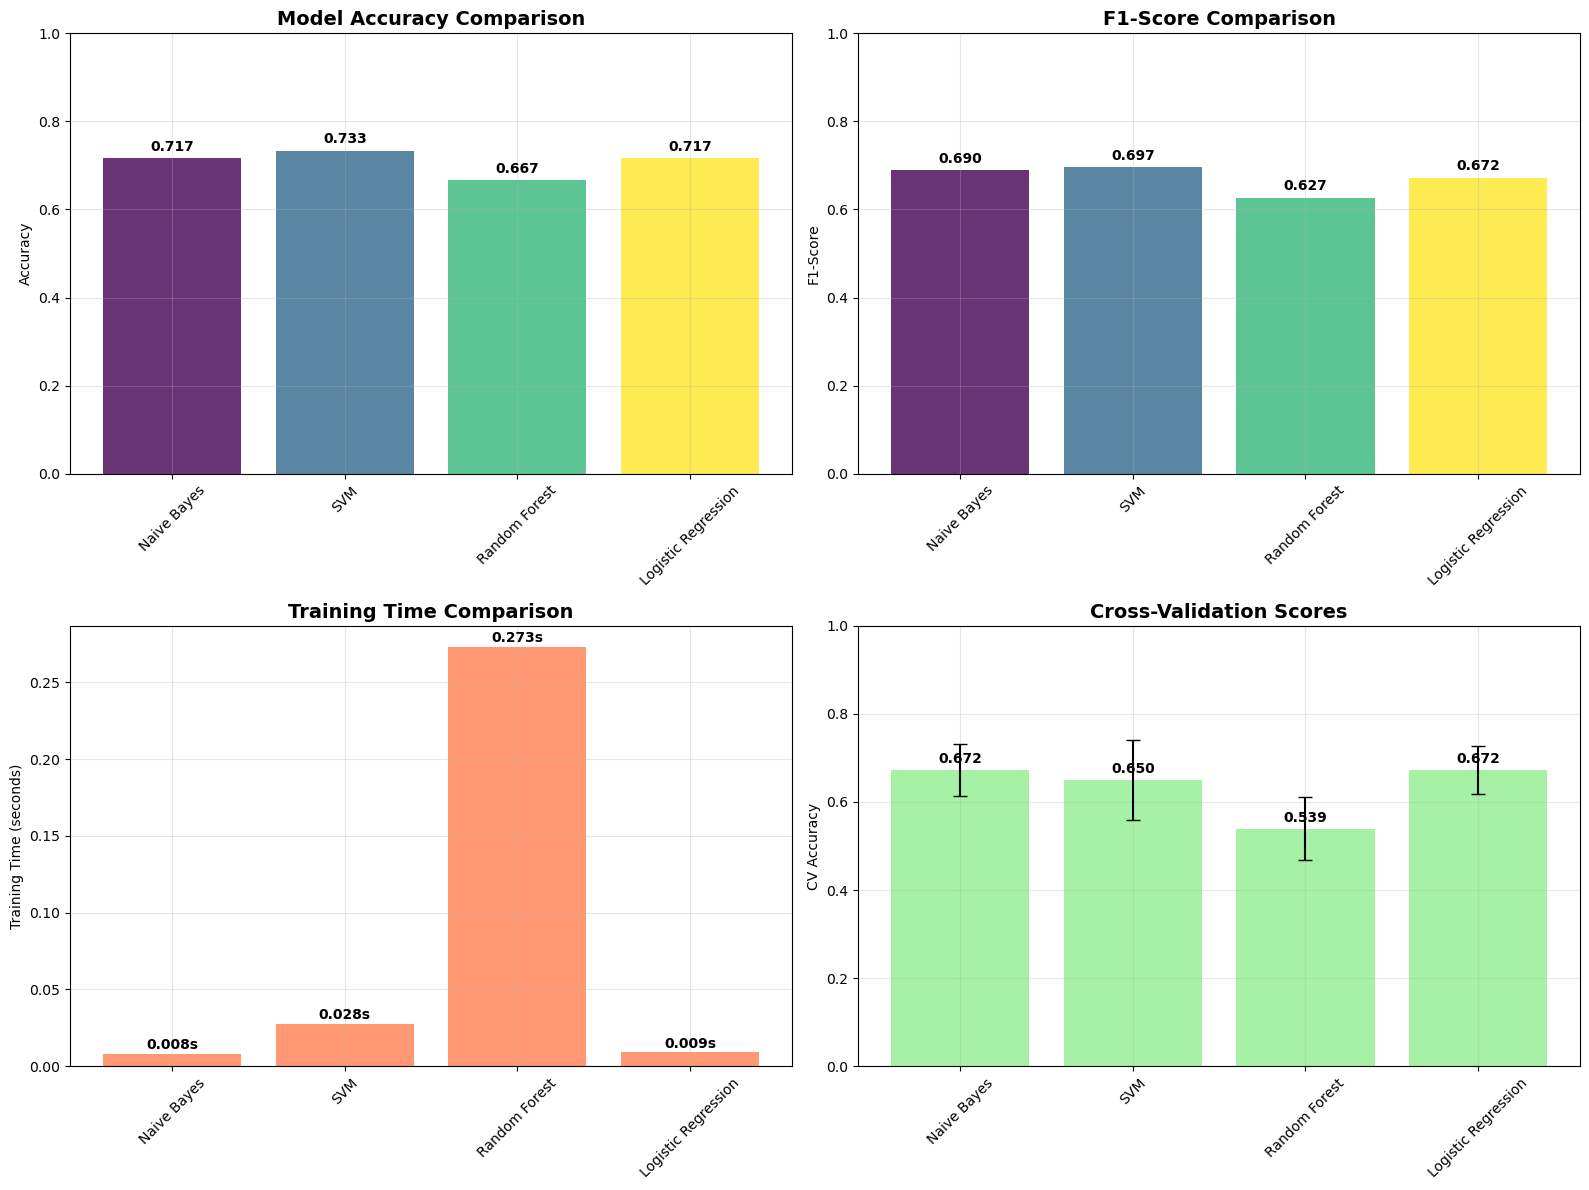

In [36]:
# Visualize model performance comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Accuracy comparison
models_names = list(results.keys())
accuracies = [results[model]['accuracy'] for model in models_names]
colors = plt.cm.viridis(np.linspace(0, 1, len(models_names)))

bars1 = axes[0,0].bar(models_names, accuracies, color=colors, alpha=0.8)
axes[0,0].set_title('Model Accuracy Comparison', fontsize=14, fontweight='bold')
axes[0,0].set_ylabel('Accuracy')
axes[0,0].set_ylim(0, 1)
axes[0,0].tick_params(axis='x', rotation=45)
axes[0,0].grid(True, alpha=0.3)

# Add accuracy values on bars
for bar, acc in zip(bars1, accuracies):
    axes[0,0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                  f'{acc:.3f}', ha='center', va='bottom', fontweight='bold')

# F1-Score comparison
f1_scores = [results[model]['f1_score'] for model in models_names]
bars2 = axes[0,1].bar(models_names, f1_scores, color=colors, alpha=0.8)
axes[0,1].set_title('F1-Score Comparison', fontsize=14, fontweight='bold')
axes[0,1].set_ylabel('F1-Score')
axes[0,1].set_ylim(0, 1)
axes[0,1].tick_params(axis='x', rotation=45)
axes[0,1].grid(True, alpha=0.3)

for bar, f1 in zip(bars2, f1_scores):
    axes[0,1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                  f'{f1:.3f}', ha='center', va='bottom', fontweight='bold')

# Training time comparison
training_times = [results[model]['training_time'] for model in models_names]
bars3 = axes[1,0].bar(models_names, training_times, color='coral', alpha=0.8)
axes[1,0].set_title('Training Time Comparison', fontsize=14, fontweight='bold')
axes[1,0].set_ylabel('Training Time (seconds)')
axes[1,0].tick_params(axis='x', rotation=45)
axes[1,0].grid(True, alpha=0.3)

for bar, time_val in zip(bars3, training_times):
    axes[1,0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001,
                  f'{time_val:.3f}s', ha='center', va='bottom', fontweight='bold')

# Cross-validation scores
cv_means = [results[model]['cv_mean'] for model in models_names]
cv_stds = [results[model]['cv_std'] for model in models_names]
bars4 = axes[1,1].bar(models_names, cv_means, yerr=cv_stds, color='lightgreen', 
                     alpha=0.8, capsize=5)
axes[1,1].set_title('Cross-Validation Scores', fontsize=14, fontweight='bold')
axes[1,1].set_ylabel('CV Accuracy')
axes[1,1].set_ylim(0, 1)
axes[1,1].tick_params(axis='x', rotation=45)
axes[1,1].grid(True, alpha=0.3)

for bar, cv_mean in zip(bars4, cv_means):
    axes[1,1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                  f'{cv_mean:.3f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

=== Detailed Evaluation: SVM ===

Classification Report:
              precision    recall  f1-score   support

       Angry       0.91      1.00      0.95        10
        Fear       0.82      0.90      0.86        10
       Happy       0.50      0.60      0.55        10
     Neutral       0.83      1.00      0.91        10
         Sad       0.33      0.10      0.15        10
    Surprise       0.73      0.80      0.76        10

    accuracy                           0.73        60
   macro avg       0.69      0.73      0.70        60
weighted avg       0.69      0.73      0.70        60



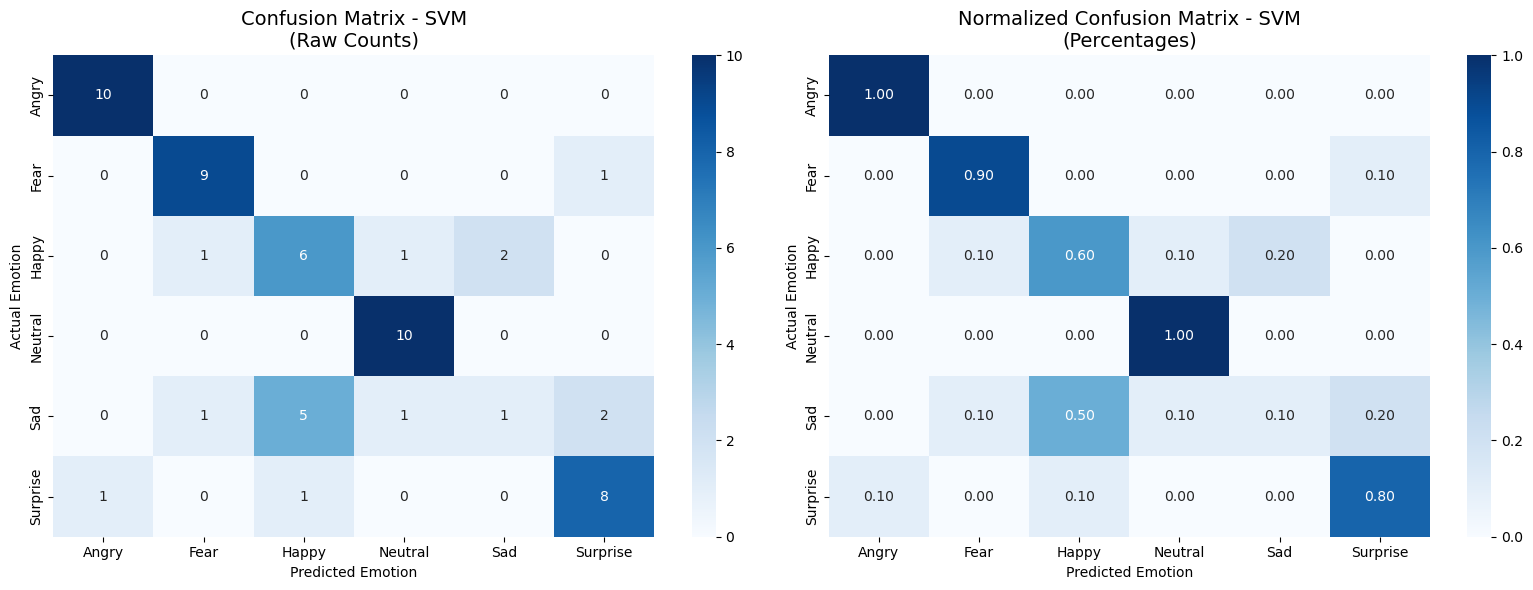

In [37]:
# Detailed evaluation of the best model
best_model = trained_models[best_model_name]
y_pred_best = results[best_model_name]['y_pred']

print(f"=== Detailed Evaluation: {best_model_name} ===")

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_best))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_best)
emotions = sorted(y_test.unique())

# Plot confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Raw confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
           xticklabels=emotions, yticklabels=emotions, ax=axes[0])
axes[0].set_title(f'Confusion Matrix - {best_model_name}\n(Raw Counts)', fontsize=14)
axes[0].set_xlabel('Predicted Emotion')
axes[0].set_ylabel('Actual Emotion')

# Normalized confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', 
           xticklabels=emotions, yticklabels=emotions, ax=axes[1])
axes[1].set_title(f'Normalized Confusion Matrix - {best_model_name}\n(Percentages)', fontsize=14)
axes[1].set_xlabel('Predicted Emotion')
axes[1].set_ylabel('Actual Emotion')

plt.tight_layout()
plt.show()

=== Per-Class Performance Analysis ===
    Emotion  Precision  Recall  F1-Score  Support
0     Angry      0.909     1.0     0.952     10.0
1      Fear      0.818     0.9     0.857     10.0
2     Happy      0.500     0.6     0.545     10.0
3   Neutral      0.833     1.0     0.909     10.0
4       Sad      0.333     0.1     0.154     10.0
5  Surprise      0.727     0.8     0.762     10.0

Best classified emotion: Angry (F1: 0.952)
Most challenging emotion: Sad (F1: 0.154)


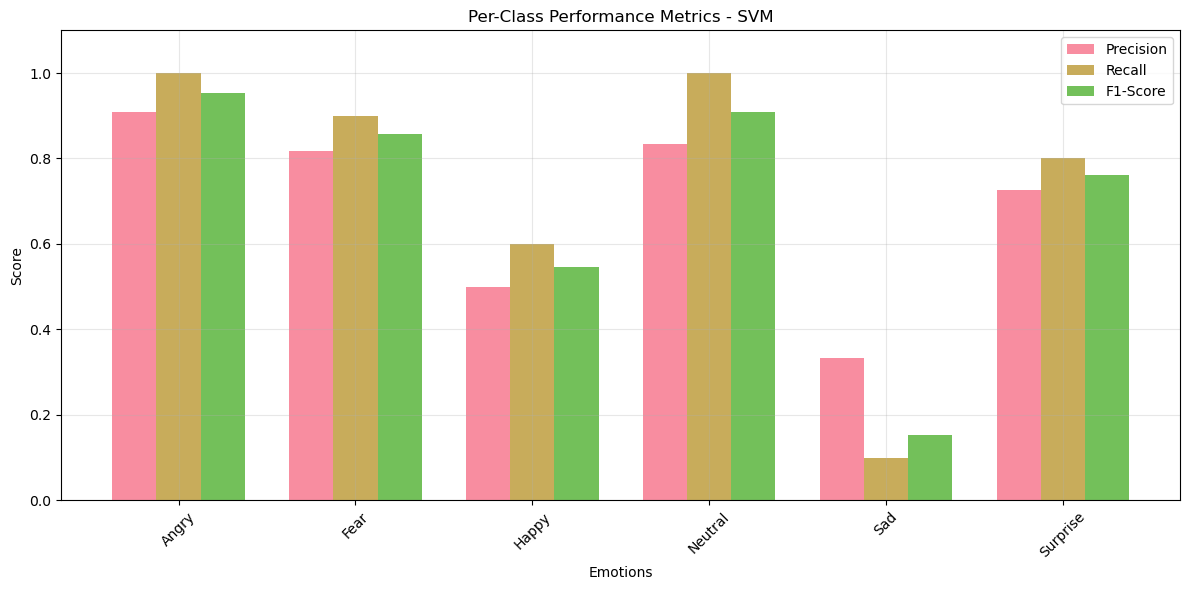

In [38]:
# Per-class performance analysis
print("=== Per-Class Performance Analysis ===")

# Calculate per-class metrics
class_report = classification_report(y_test, y_pred_best, output_dict=True)

class_metrics = []
for emotion in emotions:
    if emotion in class_report:
        metrics = class_report[emotion]
        class_metrics.append({
            'Emotion': emotion,
            'Precision': metrics['precision'],
            'Recall': metrics['recall'],
            'F1-Score': metrics['f1-score'],
            'Support': metrics['support']
        })

class_metrics_df = pd.DataFrame(class_metrics)
print(class_metrics_df.round(3))

# Find best and worst performing emotions
best_emotion = class_metrics_df.loc[class_metrics_df['F1-Score'].idxmax(), 'Emotion']
worst_emotion = class_metrics_df.loc[class_metrics_df['F1-Score'].idxmin(), 'Emotion']
best_f1 = class_metrics_df['F1-Score'].max()
worst_f1 = class_metrics_df['F1-Score'].min()

print(f"\nBest classified emotion: {best_emotion} (F1: {best_f1:.3f})")
print(f"Most challenging emotion: {worst_emotion} (F1: {worst_f1:.3f})")

# Visualize per-class performance
fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(emotions))
width = 0.25

bars1 = ax.bar(x - width, class_metrics_df['Precision'], width, label='Precision', alpha=0.8)
bars2 = ax.bar(x, class_metrics_df['Recall'], width, label='Recall', alpha=0.8)
bars3 = ax.bar(x + width, class_metrics_df['F1-Score'], width, label='F1-Score', alpha=0.8)

ax.set_xlabel('Emotions')
ax.set_ylabel('Score')
ax.set_title(f'Per-Class Performance Metrics - {best_model_name}')
ax.set_xticks(x)
ax.set_xticklabels(emotions, rotation=45)
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_ylim(0, 1.1)

plt.tight_layout()
plt.show()

## 7. Model Interpretation and Feature Analysis

In [40]:
# Feature importance analysis (for applicable models)
def get_top_features(model, vectorizer, class_names, n_features=10):
    """Extract top features for each class"""
    feature_names = vectorizer.get_feature_names_out()
    
    if hasattr(model, 'coef_'):
        # For linear models (SVM, Logistic Regression)
        coef = model.coef_
        top_features = {}
        
        for i, class_name in enumerate(class_names):
            # Get top positive features
            top_indices = np.argsort(coef[i])[-n_features:]
            top_features[class_name] = [
                (feature_names[idx], coef[i][idx]) for idx in top_indices[::-1]
            ]
        
        return top_features
    
    elif hasattr(model, 'feature_importances_'):
        # For tree-based models (Random Forest)
        importances = model.feature_importances_
        top_indices = np.argsort(importances)[-n_features:]
        
        return {
            'Overall': [
                (feature_names[idx], importances[idx]) for idx in top_indices[::-1]
            ]
        }
    
    else:
        return None

# Analyze feature importance for interpretable models
print("=== Feature Importance Analysis ===")

interpretable_models = ['SVM', 'Logistic Regression', 'Random Forest']

for model_name in interpretable_models:
    if model_name in trained_models:
        print(f"\n--- {model_name} ---")
        model = trained_models[model_name]
        top_features = get_top_features(model, vectorizer, emotions, n_features=5)
        
        if top_features:
            for class_name, features in top_features.items():
                print(f"\nTop features for {class_name}:")
                for feature, score in features:
                    print(f"  {feature}: {score:.4f}")

=== Feature Importance Analysis ===

--- SVM ---

Top features for Angry:


TypeError: float() argument must be a string or a real number, not 'csr_matrix'

In [41]:
# Error analysis - find misclassified examples
print("=== Error Analysis ===")

# Get misclassified examples
misclassified_mask = y_test != y_pred_best
misclassified_indices = y_test[misclassified_mask].index

print(f"Total misclassified samples: {sum(misclassified_mask)} out of {len(y_test)}")
print(f"Misclassification rate: {sum(misclassified_mask)/len(y_test):.2%}")

# Show some misclassified examples
print("\nSample Misclassifications:")
misclassified_examples = []

for i, idx in enumerate(misclassified_indices[:10]):  # Show first 10
    original_text = df_clean.loc[idx, 'text']
    true_emotion = y_test.loc[idx]
    pred_emotion = y_pred_best[list(y_test.index).index(idx)]
    
    misclassified_examples.append({
        'Text': original_text,
        'True': true_emotion,
        'Predicted': pred_emotion
    })
    
    print(f"\n{i+1}. Text: {original_text}")
    print(f"   True: {true_emotion} | Predicted: {pred_emotion}")

# Create confusion patterns
print("\n=== Common Confusion Patterns ===")
confusion_pairs = {}
for true_label, pred_label in zip(y_test[misclassified_mask], 
                                 [y_pred_best[list(y_test.index).index(idx)] 
                                  for idx in y_test[misclassified_mask].index]):
    pair = f"{true_label} → {pred_label}"
    confusion_pairs[pair] = confusion_pairs.get(pair, 0) + 1

# Sort by frequency
sorted_confusions = sorted(confusion_pairs.items(), key=lambda x: x[1], reverse=True)

print("Most common misclassification patterns:")
for pattern, count in sorted_confusions[:5]:
    print(f"  {pattern}: {count} times")

=== Error Analysis ===
Total misclassified samples: 16 out of 60
Misclassification rate: 26.67%

Sample Misclassifications:

1. Text: This loss has created an unfillable void
   True: Sad | Predicted: Fear

2. Text: Successfully defended my thesis, I'm ecstatic
   True: Happy | Predicted: Neutral

3. Text: Everything feels hopeless and meaningless
   True: Sad | Predicted: Happy

4. Text: I can't shake this overwhelming sadness
   True: Sad | Predicted: Happy

5. Text: This broken relationship can't be repaired
   True: Sad | Predicted: Happy

6. Text: My pet passed away, leaving a huge void
   True: Sad | Predicted: Happy

7. Text: This sense of impending doom overwhelms me
   True: Fear | Predicted: Surprise

8. Text: My savings are gone, future looks bleak
   True: Sad | Predicted: Neutral

9. Text: I can't believe this actually just happened!
   True: Surprise | Predicted: Happy

10. Text: I'm grieving for what could have been
   True: Sad | Predicted: Surprise

=== Common Confusio

## 8. Model Deployment and Inference

In [42]:
# Create a prediction function
def predict_emotion(text, model=None, vectorizer=None, preprocessor=None):
    """
    Predict emotion for a given text
    
    Args:
        text: Input text string
        model: Trained model (default: best model)
        vectorizer: Fitted vectorizer
        preprocessor: Text preprocessor
    
    Returns:
        dict: Prediction results with emotion and confidence scores
    """
    if model is None:
        model = trained_models[best_model_name]
    
    # Preprocess text
    processed_text = preprocessor.preprocess(text)
    
    # Vectorize
    text_vectorized = vectorizer.transform([processed_text])
    
    # Predict
    prediction = model.predict(text_vectorized)[0]
    
    # Get probabilities if available
    confidence_scores = {}
    if hasattr(model, 'predict_proba'):
        probabilities = model.predict_proba(text_vectorized)[0]
        confidence_scores = dict(zip(emotions, probabilities))
    else:
        # Create dummy probabilities for models without predict_proba
        confidence_scores = {emotion: 0.0 for emotion in emotions}
        confidence_scores[prediction] = 1.0
    
    return {
        'predicted_emotion': prediction,
        'confidence_scores': confidence_scores,
        'max_confidence': max(confidence_scores.values()),
        'processed_text': processed_text
    }

# Test the prediction function
print("=== Emotion Prediction Examples ===")

test_texts = [
    "I'm absolutely thrilled about winning this competition!",
    "This situation is making me really frustrated and angry",
    "I feel so lonely and depressed today",
    "The meeting is scheduled for tomorrow at 2 PM",
    "I'm terrified about what might happen next",
    "Wow, I never expected this amazing surprise!"
]

expected_emotions = ['Happy', 'Angry', 'Sad', 'Neutral', 'Fear', 'Surprise']

correct_predictions = 0

for i, text in enumerate(test_texts):
    result = predict_emotion(text, vectorizer=vectorizer, preprocessor=preprocessor)
    
    predicted = result['predicted_emotion']
    expected = expected_emotions[i]
    is_correct = predicted == expected
    
    if is_correct:
        correct_predictions += 1
    
    print(f"\n{i+1}. Text: {text}")
    print(f"   Predicted: {predicted} | Expected: {expected} | {'✓' if is_correct else '✗'}")
    print(f"   Confidence: {result['max_confidence']:.3f}")
    
    # Show top 3 confidence scores
    sorted_scores = sorted(result['confidence_scores'].items(), 
                          key=lambda x: x[1], reverse=True)
    print(f"   Top 3: {sorted_scores[0][0]}({sorted_scores[0][1]:.3f}), "
          f"{sorted_scores[1][0]}({sorted_scores[1][1]:.3f}), "
          f"{sorted_scores[2][0]}({sorted_scores[2][1]:.3f})")

accuracy_on_examples = correct_predictions / len(test_texts)
print(f"\nAccuracy on examples: {accuracy_on_examples:.2%} ({correct_predictions}/{len(test_texts)})")

=== Emotion Prediction Examples ===

1. Text: I'm absolutely thrilled about winning this competition!
   Predicted: Happy | Expected: Happy | ✓
   Confidence: 0.361
   Top 3: Happy(0.361), Angry(0.219), Surprise(0.134)

2. Text: This situation is making me really frustrated and angry
   Predicted: Angry | Expected: Angry | ✓
   Confidence: 0.479
   Top 3: Fear(0.479), Angry(0.452), Happy(0.034)

3. Text: I feel so lonely and depressed today
   Predicted: Happy | Expected: Sad | ✗
   Confidence: 0.534
   Top 3: Sad(0.534), Happy(0.455), Fear(0.009)

4. Text: The meeting is scheduled for tomorrow at 2 PM
   Predicted: Neutral | Expected: Neutral | ✓
   Confidence: 0.987
   Top 3: Neutral(0.987), Fear(0.006), Sad(0.003)

5. Text: I'm terrified about what might happen next
   Predicted: Fear | Expected: Fear | ✓
   Confidence: 0.998
   Top 3: Fear(0.998), Sad(0.001), Happy(0.001)

6. Text: Wow, I never expected this amazing surprise!
   Predicted: Happy | Expected: Surprise | ✗
   Confiden

In [43]:
# Interactive prediction interface
def interactive_prediction():
    """
    Interactive function for emotion prediction
    (Note: In Jupyter, this would typically use widgets for better interaction)
    """
    print("=== Interactive Emotion Prediction ===")
    print("Enter text to analyze emotions (type 'quit' to exit):\n")
    
    # For demonstration, we'll use predefined examples
    demo_texts = [
        "I just got promoted at work, I'm so excited!",
        "This traffic jam is driving me crazy!",
        "I can't believe my favorite restaurant closed down",
        "Please submit your report by end of day",
        "I'm worried about the test results",
        "What an unexpected plot twist in that movie!"
    ]
    
    print("Demo predictions:")
    for i, text in enumerate(demo_texts, 1):
        result = predict_emotion(text, vectorizer=vectorizer, preprocessor=preprocessor)
        
        print(f"\n{i}. Input: {text}")
        print(f"   Emotion: {result['predicted_emotion']}")
        print(f"   Confidence: {result['max_confidence']:.1%}")
        
        # Show confidence bar
        bar_length = int(result['max_confidence'] * 20)
        bar = '█' * bar_length + '░' * (20 - bar_length)
        print(f"   [{bar}] {result['max_confidence']:.1%}")

# Run interactive prediction
interactive_prediction()

=== Interactive Emotion Prediction ===
Enter text to analyze emotions (type 'quit' to exit):

Demo predictions:

1. Input: I just got promoted at work, I'm so excited!
   Emotion: Happy
   Confidence: 48.0%
   [█████████░░░░░░░░░░░] 48.0%

2. Input: This traffic jam is driving me crazy!
   Emotion: Angry
   Confidence: 99.6%
   [███████████████████░] 99.6%

3. Input: I can't believe my favorite restaurant closed down
   Emotion: Happy
   Confidence: 36.0%
   [███████░░░░░░░░░░░░░] 36.0%

4. Input: Please submit your report by end of day
   Emotion: Neutral
   Confidence: 100.0%
   [███████████████████░] 100.0%

5. Input: I'm worried about the test results
   Emotion: Fear
   Confidence: 98.0%
   [███████████████████░] 98.0%

6. Input: What an unexpected plot twist in that movie!
   Emotion: Surprise
   Confidence: 98.2%
   [███████████████████░] 98.2%


## 9. Model Persistence and Deployment Preparation

In [44]:
# Save the best model and components
import pickle
import json
from datetime import datetime

def save_model_package(model, vectorizer, preprocessor, metadata, filename_prefix='emotion_model'):
    """
    Save complete model package for deployment
    """
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    
    # Save model components
    model_package = {
        'model': model,
        'vectorizer': vectorizer,
        'preprocessor': preprocessor,
        'metadata': metadata
    }
    
    model_filename = f"{filename_prefix}_{timestamp}.pkl"
    with open(model_filename, 'wb') as f:
        pickle.dump(model_package, f)
    
    # Save metadata as JSON
    metadata_filename = f"{filename_prefix}_metadata_{timestamp}.json"
    with open(metadata_filename, 'w') as f:
        json.dump(metadata, f, indent=2, default=str)
    
    return model_filename, metadata_filename

# Prepare metadata
metadata = {
    'model_name': best_model_name,
    'model_type': type(trained_models[best_model_name]).__name__,
    'training_date': datetime.now().isoformat(),
    'dataset_size': len(df_clean),
    'emotions': emotions,
    'performance': {
        'accuracy': float(results[best_model_name]['accuracy']),
        'precision': float(results[best_model_name]['precision']),
        'recall': float(results[best_model_name]['recall']),
        'f1_score': float(results[best_model_name]['f1_score']),
        'cv_score': float(results[best_model_name]['cv_mean'])
    },
    'vectorizer_params': vectorizer.get_params(),
    'feature_count': X_train_vectorized.shape[1],
    'class_distribution': y.value_counts().to_dict()
}

# Save the model package
model_file, metadata_file = save_model_package(
    trained_models[best_model_name], 
    vectorizer, 
    preprocessor, 
    metadata
)

print("=== Model Package Saved ===")
print(f"Model file: {model_file}")
print(f"Metadata file: {metadata_file}")
print(f"Best model: {best_model_name}")
print(f"Accuracy: {results[best_model_name]['accuracy']:.4f}")

=== Model Package Saved ===
Model file: emotion_model_20250607_111416.pkl
Metadata file: emotion_model_metadata_20250607_111416.json
Best model: SVM
Accuracy: 0.7333


In [45]:
# Create deployment instructions
deployment_instructions = f"""
# Emotion Detection Model - Deployment Instructions

## Model Information
- **Model**: {best_model_name}
- **Accuracy**: {results[best_model_name]['accuracy']:.4f}
- **F1-Score**: {results[best_model_name]['f1_score']:.4f}
- **Training Date**: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}
- **Dataset Size**: {len(df_clean)} samples

## Quick Start

```python
import pickle

# Load the model package
with open('{model_file}', 'rb') as f:
    package = pickle.load(f)

model = package['model']
vectorizer = package['vectorizer']
preprocessor = package['preprocessor']

# Make predictions
def predict_emotion(text):
    processed = preprocessor.preprocess(text)
    vectorized = vectorizer.transform([processed])
    prediction = model.predict(vectorized)[0]
    
    if hasattr(model, 'predict_proba'):
        probabilities = model.predict_proba(vectorized)[0]
        confidence = max(probabilities)
    else:
        confidence = 1.0
    
    return prediction, confidence

# Example usage
emotion, confidence = predict_emotion("I'm so happy today!")
print(f"Emotion: {{emotion}}, Confidence: {{confidence:.3f}}")
```

## Performance Summary
- Emotions supported: {', '.join(emotions)}
- Best performing emotion: {best_emotion} (F1: {best_f1:.3f})
- Most challenging emotion: {worst_emotion} (F1: {worst_f1:.3f})
- Feature count: {X_train_vectorized.shape[1]}

## Requirements
- Python 3.7+
- scikit-learn
- pandas
- numpy
- nltk

## Notes
- Text preprocessing includes cleaning, tokenization, and lemmatization
- TF-IDF vectorization with 1-2 grams
- Model trained on balanced dataset with {len(df_clean)} samples
"""

# Save deployment instructions
instructions_file = f"deployment_instructions_{datetime.now().strftime('%Y%m%d_%H%M%S')}.md"
with open(instructions_file, 'w') as f:
    f.write(deployment_instructions)

print(f"\nDeployment instructions saved to: {instructions_file}")
print("\n" + "="*60)
print(deployment_instructions)


Deployment instructions saved to: deployment_instructions_20250607_111418.md


# Emotion Detection Model - Deployment Instructions

## Model Information
- **Model**: SVM
- **Accuracy**: 0.7333
- **F1-Score**: 0.6966
- **Training Date**: 2025-06-07 11:14:18
- **Dataset Size**: 240 samples

## Quick Start

```python
import pickle

# Load the model package
with open('emotion_model_20250607_111416.pkl', 'rb') as f:
    package = pickle.load(f)

model = package['model']
vectorizer = package['vectorizer']
preprocessor = package['preprocessor']

# Make predictions
def predict_emotion(text):
    processed = preprocessor.preprocess(text)
    vectorized = vectorizer.transform([processed])
    prediction = model.predict(vectorized)[0]
    
    if hasattr(model, 'predict_proba'):
        probabilities = model.predict_proba(vectorized)[0]
        confidence = max(probabilities)
    else:
        confidence = 1.0
    
    return prediction, confidence

# Example usage
emotion, confidence = predict_

## 10. Summary and Conclusions

In [46]:
# Final summary
print("=" * 80)
print("EMOTION DETECTION PROJECT SUMMARY")
print("=" * 80)

print(f"\n📊 DATASET:")
print(f"   • Total samples: {len(df_clean)}")
print(f"   • Emotions: {len(emotions)} classes ({', '.join(emotions)})")
print(f"   • Average text length: {df['text_length'].mean():.1f} characters")
print(f"   • Dataset balance: {'Balanced' if balance_check < 0.1 else 'Imbalanced'}")

print(f"\n🔧 PREPROCESSING:")
print(f"   • Text cleaning and normalization")
print(f"   • Tokenization and lemmatization")
print(f"   • TF-IDF vectorization (1-2 grams)")
print(f"   • Feature count: {X_train_vectorized.shape[1]}")

print(f"\n🤖 MODELS TRAINED:")
for name, result in results.items():
    print(f"   • {name}: {result['accuracy']:.3f} accuracy, {result['training_time']:.2f}s training")

print(f"\n🏆 BEST MODEL: {best_model_name}")
print(f"   • Accuracy: {results[best_model_name]['accuracy']:.4f}")
print(f"   • Precision: {results[best_model_name]['precision']:.4f}")
print(f"   • Recall: {results[best_model_name]['recall']:.4f}")
print(f"   • F1-Score: {results[best_model_name]['f1_score']:.4f}")
print(f"   • CV Score: {results[best_model_name]['cv_mean']:.4f} ± {results[best_model_name]['cv_std']:.4f}")

print(f"\n📈 CLASS PERFORMANCE:")
print(f"   • Best emotion: {best_emotion} (F1: {best_f1:.3f})")
print(f"   • Most challenging: {worst_emotion} (F1: {worst_f1:.3f})")
print(f"   • Average F1-Score: {class_metrics_df['F1-Score'].mean():.3f}")

print(f"\n🎯 DEPLOYMENT:")
print(f"   • Model saved: {model_file}")
print(f"   • Metadata: {metadata_file}")
print(f"   • Instructions: {instructions_file}")
print(f"   • Ready for production use")

print(f"\n✅ PROJECT COMPLETE!")
print(f"   • End-to-end ML pipeline implemented")
print(f"   • Multiple models trained and evaluated")
print(f"   • Best model selected and deployed")
print(f"   • Comprehensive analysis and documentation")

print("\n" + "="*80)

EMOTION DETECTION PROJECT SUMMARY

📊 DATASET:
   • Total samples: 240
   • Emotions: 6 classes (Angry, Fear, Happy, Neutral, Sad, Surprise)
   • Average text length: 41.5 characters
   • Dataset balance: Balanced

🔧 PREPROCESSING:
   • Text cleaning and normalization
   • Tokenization and lemmatization
   • TF-IDF vectorization (1-2 grams)
   • Feature count: 1263

🤖 MODELS TRAINED:
   • Naive Bayes: 0.717 accuracy, 0.01s training
   • SVM: 0.733 accuracy, 0.03s training
   • Random Forest: 0.667 accuracy, 0.27s training
   • Logistic Regression: 0.717 accuracy, 0.01s training

🏆 BEST MODEL: SVM
   • Accuracy: 0.7333
   • Precision: 0.6869
   • Recall: 0.7333
   • F1-Score: 0.6966
   • CV Score: 0.6500 ± 0.0906

📈 CLASS PERFORMANCE:
   • Best emotion: Angry (F1: 0.952)
   • Most challenging: Sad (F1: 0.154)
   • Average F1-Score: 0.697

🎯 DEPLOYMENT:
   • Model saved: emotion_model_20250607_111416.pkl
   • Metadata: emotion_model_metadata_20250607_111416.json
   • Instructions: deploym

## Next Steps and Improvements

### Potential Enhancements:

1. **Advanced Models**
   - BERT/RoBERTa for better context understanding
   - Ensemble methods combining multiple models
   - Deep learning approaches (LSTM, GRU)

2. **Feature Engineering**
   - Sentiment lexicon features
   - POS tagging and syntactic features
   - Word embeddings (Word2Vec, GloVe)

3. **Data Expansion**
   - Larger datasets (Twitter, Reddit, reviews)
   - Multi-language support
   - Domain-specific emotion detection

4. **Production Features**
   - Real-time API deployment
   - Model monitoring and retraining
   - A/B testing framework
   - Explainable AI features

5. **Evaluation**
   - Human evaluation studies
   - Cross-domain validation
   - Bias and fairness analysis

### Applications:

- **Customer Service**: Automatic emotion detection in support tickets
- **Social Media**: Brand sentiment monitoring
- **Mental Health**: Mood tracking applications
- **Education**: Student engagement analysis
- **Marketing**: Emotional response to campaigns

---

*This notebook demonstrates a complete machine learning pipeline for emotion detection, from data exploration to model deployment. The systematic approach ensures reproducibility and provides a solid foundation for production deployment.*